In [ ]:
#  Steps of the work:

# Make a model with accessible parameters using TensorFlow 2.x
# Write an entropy loss and add it to the network parameters for training.
# Train a model by jointly optimizing its loss (e.g. cross entropy for classification) and the entropy for compressability.
# Compress the model parameters using Huffman coding.
# Analyze the results and trade-off between accuracy and compressability.
# Write a model wrapper that can read and write the compressed parameters.

# Notes:

# Can be started on simple datasets like MNIST.
# Can start from simple MLP NNs. And then extend to convs. The implementation should be generic enough so that it can support any layer.
# Bonus: add support for normalization layers: batch norm, instance norm, etc.

In [1]:
# Load MNIST data set

from tensorflow.keras.datasets import mnist
train_set, test_set = mnist.load_data()

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Allocation of 17179869184 exceeds 10% of free system memory.

In [3]:
# generate a simple NN model

from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
import numpy as np

    
kernel_initializer = 'he_normal'
activation = "relu"

def get_model(chs=256):
    shape=(28,28,1)
    
    inputs = Input(shape)
    layer = Flatten()(inputs)
    layer = Dense(units=chs, activation=activation, kernel_initializer=kernel_initializer)(layer)
    layer = Dense(units=chs, activation=activation, kernel_initializer=kernel_initializer)(layer)
    output = Dense(10, activation='linear', use_bias=True, kernel_initializer=kernel_initializer)(layer)

    model = Model(inputs, output)
    return model



In [8]:
# model.layers

NameError: name 'model' is not defined

In [23]:
# model.layers[0]

In [25]:
# model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(784, 256) dtype=float32, numpy=
 array([[ 0.04747557, -0.0241543 ,  0.06825899, ..., -0.06088347,
         -0.01428646,  0.09181509],
        [ 0.01840485, -0.08634035, -0.05705916, ...,  0.06484796,
         -0.08538831, -0.06986799],
        [ 0.08091406,  0.09522551,  0.06740516, ..., -0.02281002,
          0.06427108, -0.05539102],
        ...,
        [ 0.0265468 , -0.02665523,  0.01700675, ..., -0.02849575,
          0.06601989,  0.06358932],
        [ 0.01959939, -0.0224366 ,  0.00977207, ..., -0.00086983,
          0.11475715, -0.05219548],
        [ 0.01873984,  0.05438872, -0.04925571, ...,  0.08855245,
          0.06425571,  0.05567208]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(256,) dtype=float32, numpy=
 array([-0.01938667, -0.02402712, -0.02026186, -0.01597225, -0.01930892,
        -0.02138305, -0.02111024, -0.01609827, -0.01176102, -0.01660232,
        -0.01214598, -0.02503965, -0.00847238, -0.01553644, -0.02141835,
    

In [97]:
# tf.reduce_sum(np.arange(100).reshape((10,10)), axis=0, keepdims=True)



<tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[450, 460, 470, 480, 490, 500, 510, 520, 530, 540]])>

In [13]:
#     To estimate the histogram, we first remove outliers in the
# activations if the samples are outside the range [μ−3σ; μ+3σ]

def calculate_entropy_range(variables, scale = 3):
    std = tf.math.reduce_variance(variables)**0.5
    if std==0.0:
        std = 1.0
    mean = tf.math.reduce_mean(variables)
    return mean - std*scale, mean + std*scale
    
bins = np.arange(256, dtype=np.float32)
bins = tf.convert_to_tensor(bins)
bins = tf.reshape(bins, (1,-1))

def calculate_weights(variables, min_h, max_h):
#     variables (numpy.ndarray): The variables to calculate the weights for.
#         min_h (float): The minimum value of the histogram bins.
#         max_h (float): The maximum value of the histogram bins.
# xk: tf.Tensor(203.77649, shape=(), dtype=float32),tj: 0.0,tj1: 0.0,tj2: 1.0,delta: 1.0
# xk: tf.Tensor(203.77649, shape=(), dtype=float32),tj: 1.0,tj1: 0.0,tj2: 2.0,delta: 2.0
# xk: tf.Tensor(203.77649, shape=(), dtype=float32),tj: 2.0,tj1: 1.0,tj2: 3.0,delta: 2.0
# xk: tf.Tensor(203.77649, shape=(), dtype=float32),tj: 3.0,tj1: 2.0,tj2: 4.0,delta: 2.0
    nbins = 256
    deltas = np.zeros((nbins,variables.shape[0])) # j,k
    t = np.linspace(0, nbins - 1, nbins) # Return evenly spaced numbers over a specified interval.
#     print(variables)
# change for loop to array way , operation
# matrix way in vector way

    for j in range(nbins):
        for k in range(len(variables[j])):
            xk = variables[j][k] # weight
            tj = t[j] # bins t[j] and j are same
            tj1 = t[max(0, j-1)]
            tj2 = t[min(nbins-1, j+1)]
#                 print('tj ' + str(tj) + ',tj1 ' + str(tj1) + ',tj2' + str(tj2) + ',delta' + str(tj2 - tj1))
            w = weight(xk, tj, tj1, tj2, nbins)
            deltas[j,k] += w
#                 index = tf.constant([i + j*nbins])  # Create index tensor
#                 update = tf.constant(w)   # Create update tensor
#                 weights = tf.tensor_scatter_nd_add(weights, index, update)  # Update weights tensor

    return deltas

def weight(xk, tj, tj1, tj2, nbins):
#         xk (float): The input value to calculate the weight for.
#         tj (float): The current node.
#         tj1 (float): The previous node.
#         tj2 (float): The next node.
#    if xk ∈ [tj−1; tj ] then (xk − tj−1)/Δ
#     if xk ∈ [tj ; tj+1] then (tj+1 − xk)/Δ
#     otherwise return 0
#     xk = tf.cast(xk, tf.double)
#     tj = tf.cast(tj, tf.double)
#     tj1 = tf.cast(tj1, tf.double)
#     tj2 = tf.cast(tj2, tf.double)
    delta = 1.0 / nbins
#     print('xk: ' + str(xk) + ',tj: ' + str(tj) + ',tj1: ' + str(tj1) + ',tj2: ' + str(tj2) + ',delta: ' + str(tj2 - tj1))
    if tj1 <= xk and xk <= tj:
#         print('1: ' + str((xk - tj1) / delta))
        return (xk - tj1) / delta
    elif tj <= xk and xk <= tj2:
#         print('2: ' + str((tj2 - xk) / delta))
        return (tj2 - xk) / delta
    else:
        return 0.0

def calculate_histogram(variables, min_h, max_h):
    flat_vars = tf.reshape(variables, (-1,1))
    scaled_vars = (flat_vars-min_h)*255/(max_h-min_h)
    diff = calculate_weights(scaled_vars, min_h, max_h)
    diff = tf.reshape(diff, (-1,1))
    diff = tf.cast(diff, tf.float32)
    diff = bins - diff
#     print(diff) # shape = (256,) -> (65536, 1) or (16777216, 1)
#     print(np.count_nonzero(diff))
# (16777216, 1), dtype=float32)
# 512
#     diff = bins - scaled_vars
#     print(bins) # shape = (1,256)
#     print(scaled_vars) # shape=(65536, 1)
#     print(bins - scaled_vars) # shape=(65536, 256)
#     print(bins - diff) # shape=(1, 256)
    p_ = tf.exp(-(diff**2))
    p = p_ / (tf.reduce_sum(p_, axis=1, keepdims=True)+1e-10)
    hist = tf.reduce_sum(p, axis=0)
    return hist

def calculate_entropy(variables, eps=1e-10):
#     print(variables)
#     variables shape (784, 256)
#     print('gg')
    # TODO implement
    # here you need to also output the range of the compressed data (minimum, maximum)
#     return 0
    # Calculate the histogram of the variables
#     hist, bin_edges = np.histogram(variables, bins='auto')
    
#     # Convert the histogram to probabilities
#     probs = hist / np.sum(hist)
    
#     # Calculate the entropy
#     entropy = -np.sum(probs * np.log2(probs))
    
#     # Calculate the range of the compressed data
#     compressed_range = (bin_edges[0], bin_edges[-1])
# #     print(entropy, '      :::: ', compressed_range)
    
#     return entropy, compressed_range
    flat_vars = tf.reshape(variables, (-1,1))
    min_h, max_h = calculate_entropy_range(variables)
    
    hist = calculate_histogram(flat_vars, min_h, max_h)
    #hist = tf.histogram_fixed_width(flat_vars, [min_h,max_h])
    
    probs = hist / tf.reduce_sum(hist)
#     probs[probs == 0] = 1  # replace zeros with ones
    entropy = -tf.reduce_sum(probs * tf.experimental.numpy.log2(probs+eps))
#     print(entropy,':: ', np.min(flat_vars),':: ', np.max(flat_vars),':: ', bins[0],':: ',bins[1])
    return entropy, (min_h, max_h)

class CompressibleNN(keras.Model):
    def __init__(self, net_model):
        super(CompressibleNN, self).__init__()
        self.net_model = net_model
        self.CE_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def call(self, inputs):
        return self.net_model(inputs)
    
    def entropy_loss(self, inputs):
        # TODO implemment the entropy calculation here for each layer parameters
        # for each layer: calculate a histogram and from then calculate the entropy
        # return a sum of all entropies
        
        entropy = 0
#         for l in self.net_model.layers:
#             #TODO: if layer is dense:
#             for v in l.trainable_variables:
#                 # here you have a set of variable for which you can calculate the histogram and entropy
#                 entropy += calculate_entropy(v)
#         return 0
        for l in self.net_model.layers:
            if isinstance(l, keras.layers.Dense):
                for v in l.trainable_variables:
                    v_entropy, v_range = calculate_entropy(v)
                    entropy += v_entropy

        return entropy

    
    
    def train_step(self, input):
        images = input[0]
        labels = input[1]

        with tf.GradientTape() as tape:
            output = self.net_model(images)
            loss =  self.entropy_loss(images)

        # Get the gradients w.r.t the loss
        gradient = tape.gradient(loss, self.net_model.trainable_variables)
        # Update the weights using the generator optimizer
        self.optimizer.apply_gradients(
            zip(gradient, self.net_model.trainable_variables)
        )
        return {"loss": loss}
    
model = get_model()
compNN = CompressibleNN(model)
optimizer = tf.optimizers.Adam(learning_rate=1e-3, beta_1=0.9)
compNN.compile(optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [14]:
min_h, max_h = calculate_entropy_range(model.layers[3].variables[0])
our_h=calculate_histogram(model.layers[3].variables[0], min_h, max_h)
# 2023-05-10 05:12:17.009000: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
# 2023-05-10 05:12:17.467376: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
# 2023-05-10 05:12:17.512574: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17179869184 exceeds 10% of free system memory.

# xk: tf.Tensor(203.77649, shape=(), dtype=float32),tj: 0.0,tj1: 0.0,tj2: 1.0,delta: 1.0
# xk: tf.Tensor(203.77649, shape=(), dtype=float32),tj: 1.0,tj1: 0.0,tj2: 2.0,delta: 2.0
# xk: tf.Tensor(203.77649, shape=(), dtype=float32),tj: 2.0,tj1: 1.0,tj2: 3.0,delta: 2.0
# xk: tf.Tensor(203.77649, shape=(), dtype=float32),tj: 3.0,tj1: 2.0,tj2: 4.0,delta: 2.0
# xk: tf.Tensor(203.77649, shape=(), dtype=float32),tj: 4.0,tj1: 3.0,tj2: 5.0,delta: 2.0
# xk: tf.Tensor(203.77649, shape=(), dtype=float32),tj: 5.0,tj1: 4.0,tj2: 6.0,delta: 2.0
# xk: tf.Tensor(203.77649, shape=(), dtype=float32),tj: 6.0,tj1: 5.0,tj2: 7.0,delta: 2.0
# xk: tf.Tensor(203.77649, shape=(), dtype=float32),tj: 7.0,tj1: 6.0,tj2: 8.0,delta: 2.0

In [10]:
np_h=np.histogram(model.layers[3].variables[0], bins=256) # shape 256 * 257

In [ ]:
min_h, max_h = calculate_entropy_range(model.layers[3].variables[0])
our_h=calculate_histogram(model.layers[3].variables[0], min_h, max_h)


In [ ]:
our_h

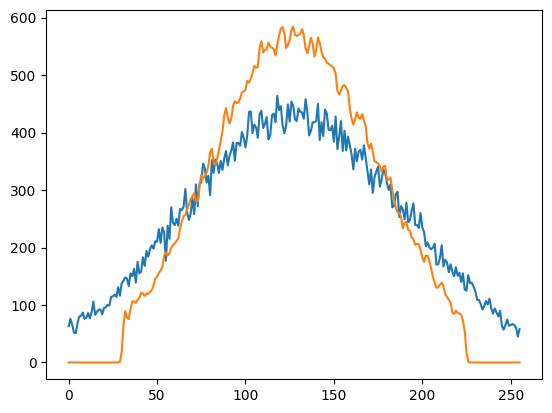

In [7]:
from matplotlib import pyplot as plt
plt.plot(np_h[0])
plt.plot(our_h)

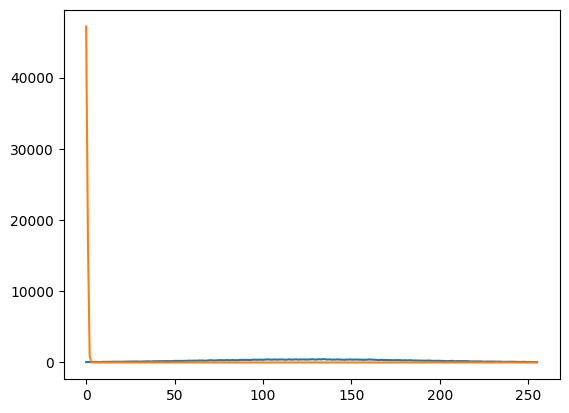

In [15]:
plt.plot(np_h[0])
plt.plot(our_h)

In [16]:
# train the model
tf.config.run_functions_eagerly(True)
# loss needs to be decreased during training
compNN.fit(x=train_set[0], y=train_set[1], epochs=1, batch_size=32)

IndexError: index 10 is out of bounds for axis 0 with size 10

In [53]:
# test performance
res = model(test_set[0])
print("test acc: ", 100*(np.argmax(res, axis=1)==test_set[1]).mean())

test acc:  96.02000000000001


In [56]:
# test performance with entropy_loss
res = model(test_set[0])
print("test acc: ", 100*(np.argmax(res, axis=1)==test_set[1]).mean())

test acc:  96.61
